In [1]:
import numpy as np
import h5py
import math
import os
import pathlib
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Activation, Layer, ReLU, LeakyReLU
from tensorflow.keras import backend as K

In [2]:
from func import *

Restructuring data with type classification using one_hot interpretation. Loading data:

In [2]:
filename = './signals/BKG_4e6_dataset.h5'
# make sure input data has correct input shape - background training data
with h5py.File(filename, 'r') as file:
    X_train = np.array(file['X_train'])
    X_test = np.array(file['X_test'])
    X_val = np.array(file['X_val'])

Define Dense NN architecture

In [2]:
import argparse
import h5py
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical


bkg_file= '/home/aadi/praktika/ADC/files/background_for_training.h5'
events=None, 
test_size=0.2 
val_size=0.2
input_shape=171

In [66]:
 # read BACKGROUND data
with h5py.File(bkg_file, 'r') as file:
    full_data = file['Particles'][:,:,:]
    np.random.seed(42)
    np.random.shuffle(full_data)# SEE KORDA
    if events: full_data = full_data[:,:,:]
        
print(full_data.shape)        
##########################Adding OH,cos(phi),sin(phi)############################################        
event_obj_type=full_data[:,:,3]#Object types from all events
events_phis=full_data[:,:,2]#extract phis
event_obj_oh=to_categorical(event_obj_type,5)#All the object types turned to one hot
event_wo_type_phi=full_data[:,:,:2]#original events without type and phi
cos_sin=np.stack((np.cos(events_phis),np.sin(events_phis)),axis=2)#stack cos and sine oh phi
event_w_trig=np.concatenate((event_wo_type_phi[:],cos_sin[:]),axis=2)#add trig
full_data=np.concatenate((event_w_trig[:],event_obj_oh[:]),axis=2)#original data combined with OH v. and trig       
##################################################################################################


# define training, test and validation datasets
X_train, X_test = train_test_split(full_data, test_size=test_size, random_state=42, shuffle=True)
X_train, X_val = train_test_split(X_train, test_size=val_size, random_state=42, shuffle=True)
#del full_data

(4000000, 19, 4)


In [20]:
full_data.reshape(len(full_data),19,4)

(4000000, 19, 9)

Different Approach to finding standardizing arguments. I will first plot out all the features, then find means and stds for all. Using redundant "for cycle". Slow but will do the job.

In [13]:
event_obj_type=event_obj_type.reshape(len(full_data),19,1)
event_trig_type=np.concatenate((event_w_trig[:],event_obj_type[:]),axis=2)
event_trig_type.shape

(4000000, 19, 5)

In [3]:
def find_stds_means_bkg(event_trig_type):
    data_output=event_trig_type #data with cos sin and type
    keys=["pt","eta","cos","sin"] #Keys for dictionries
    #initiate dictionaries
    MET={"pt" : [], "eta" : [], "cos" : [], "sin" : []}
    ELEKT={"pt" : [], "eta" : [], "cos" : [], "sin" : []}
    MUON={"pt" : [], "eta" : [], "cos" : [], "sin" : []}
    JETID={"pt" : [], "eta" : [], "cos" : [], "sin" : []}
    for i in range(len(data_output)): #loop through all events
        #met_per_event counter
        met_per_event=0
        elekt_per_event=0
        muon_per_event=0
        jets_per_event=0
    
        for j in range(19):#EVENT 19 cardinality
            j_object=data_output[i][j][4]#check for object type
            if j_object==1:
                met_per_event +=1
                for feat,key in enumerate(keys):#take needed value according to key
                    MET[key].append(data_output[i][j][feat])#add value 
            if j_object==2:
                elekt_per_event +=1
                for feat,key in enumerate(keys):
                    ELEKT[key].append(data_output[i][j][feat])
            if j_object==3:
                muon_per_event +=1
                for feat,key in enumerate(keys):
                    MUON[key].append(data_output[i][j][feat])
            if j_object==4:
                jets_per_event +=1
                for feat,key in enumerate(keys):
                    JETID[key].append(data_output[i][j][feat])
    objects={"met": MET,"elekt" : ELEKT , "muon" : MUON , "jetid" : JETID}
    mean_stds={}
    for i,obj in enumerate(objects):
        dict_mstd={}
        for i,key in enumerate(keys):
            dict_mstd[key]={"mean" : np.mean(objects[obj][key]), "std" : np.std(objects[obj][key])}
        mean_stds[obj]=dict_mstd
        
    return mean_stds

In [ ]:
#Standardizing will be straight forward also.
#0-3 indexes for met
#4-19 inedexes for elektrons
#20-35 indexes for muons
#36-75 indexes for jets

In [67]:
event_obj_type=event_obj_type.reshape(len(full_data),19,1)
event_trig_type=np.concatenate((event_w_trig[:],event_obj_type[:]),axis=2)
event_trig_type.shape

(4000000, 19, 5)

In [80]:
uus=event_trig_type[:,:,:4]

In [81]:
uus[0]

array([[-0.05202916,  0.        , -0.70097354, -1.2290017 ],
       [-0.77632834,  0.10033965,  1.20591092,  0.73980123],
       [ 0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ],
       [-0.54582719, -1.38410598,  1.12270252,  0.86021952],
       [ 0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.        ,  0.

In [69]:
tulemus=standardize_data4(event_trig_type,mean_stds)

In [70]:
mean_stds=find_stds_means_bkg(tulemus)

In [71]:
mean_stds

{'met': {'pt': {'mean': 3.855937791286124e-17, 'std': 1.0000000000000002},
  'eta': {'mean': 0.0, 'std': 0.0},
  'cos': {'mean': 1.7772450178199507e-18, 'std': 0.9999999999999997},
  'sin': {'mean': 1.2700951401711791e-17, 'std': 1.0}},
 'elekt': {'pt': {'mean': 1.6150414440918867e-16, 'std': 0.9999999999999996},
  'eta': {'mean': 1.2310997386555185e-17, 'std': 0.9999999999999992},
  'cos': {'mean': 1.5386306012062626e-17, 'std': 0.9999999999999996},
  'sin': {'mean': 4.199667493351696e-17, 'std': 0.9999999999999996}},
 'muon': {'pt': {'mean': -1.8237994402566313e-16, 'std': 1.0000000000000004},
  'eta': {'mean': -1.795374596411014e-17, 'std': 0.9999999999999998},
  'cos': {'mean': 2.3049091283192746e-17, 'std': 1.0000000000000002},
  'sin': {'mean': -2.393064556191831e-17, 'std': 0.9999999999999999}},
 'jetid': {'pt': {'mean': -1.0970731547127946e-16, 'std': 1.0000000000000002},
  'eta': {'mean': -2.2027313791196887e-17, 'std': 0.9999999999999998},
  'cos': {'mean': -2.599412567860972

In [18]:
mean_stds=find_stds_means_bkg(event_trig_type)

In [19]:
mean_stds

{'met': {'pt': {'mean': 41.4562931251135, 'std': 21.17293805870149},
  'eta': {'mean': 0.0, 'std': 0.0},
  'cos': {'mean': 6.393118361991567e-05, 'std': 0.7073504610195422},
  'sin': {'mean': 0.00028192700904651165, 'std': 0.7068629582354745}},
 'elekt': {'pt': {'mean': 37.54579381574212, 'std': 14.154425675444342},
  'eta': {'mean': -0.0003464465965275722, 'std': 1.6391985005870908},
  'cos': {'mean': -0.0007123569063861435, 'std': 0.7071327228835375},
  'sin': {'mean': 0.00039937824792517945, 'std': 0.7070803669116882}},
 'muon': {'pt': {'mean': 37.54423228260537, 'std': 14.310914876105468},
  'eta': {'mean': -0.00026549400152860674, 'std': 1.213826845838711},
  'cos': {'mean': 4.533641329742322e-05, 'std': 0.7072035329014236},
  'sin': {'mean': -5.054241930759607e-05, 'std': 0.7070100129713994}},
 'jetid': {'pt': {'mean': 33.04715481975824, 'std': 30.53014991233841},
  'eta': {'mean': -0.004052303655904774, 'std': 1.7173831134830846},
  'cos': {'mean': 0.0002957384667361168, 'std': 

In [21]:
X_mean=mean_stds["met"]["pt"]["mean"]
X_std=mean_stds["met"]["pt"]["std"]
print(X_mean)
print(X_std)

41.4562931251135
21.17293805870149


Now create assign stds and means for different features per every object type

In [62]:
mean_stds

{'met': {'pt': {'mean': 41.4562931251135, 'std': 21.17293805870149},
  'eta': {'mean': 0.0, 'std': 0.0},
  'cos': {'mean': 6.393118361991567e-05, 'std': 0.7073504610195422},
  'sin': {'mean': 0.00028192700904651165, 'std': 0.7068629582354745}},
 'elekt': {'pt': {'mean': 37.54579381574212, 'std': 14.154425675444342},
  'eta': {'mean': -0.0003464465965275722, 'std': 1.6391985005870908},
  'cos': {'mean': -0.0007123569063861435, 'std': 0.7071327228835375},
  'sin': {'mean': 0.00039937824792517945, 'std': 0.7070803669116882}},
 'muon': {'pt': {'mean': 37.54423228260537, 'std': 14.310914876105468},
  'eta': {'mean': -0.00026549400152860674, 'std': 1.213826845838711},
  'cos': {'mean': 4.533641329742322e-05, 'std': 0.7072035329014236},
  'sin': {'mean': -5.054241930759607e-05, 'std': 0.7070100129713994}},
 'jetid': {'pt': {'mean': 33.04715481975824, 'std': 30.53014991233841},
  'eta': {'mean': -0.004052303655904774, 'std': 1.7173831134830846},
  'cos': {'mean': 0.0002957384667361168, 'std': 

Text(0, 0.5, 'EVENTS')

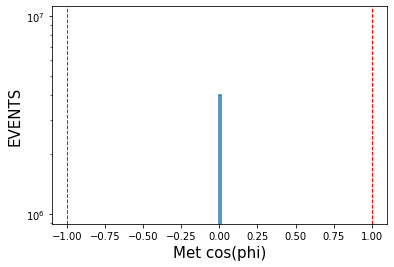

In [36]:

plt.hist(MET["eta"],bins=100, label="sin", histtype='step', fill=False, linewidth=1.5,log=True)
plt.yscale('log')
plt.axvline(1, color='red', linestyle='dashed', linewidth=1)
plt.axvline(-1, color='red', linestyle='dashed', linewidth=1)
plt.xlabel("Met cos(phi)",fontsize=15)
#if n== 0:
plt.ylabel("EVENTS",fontsize=15)
#plt.title(string+'MET cos(phi) vs events',fontsize=15)

In [174]:

test_data=event_w_trig

In [175]:
test_data2=test_data.reshape(len(test_data),76)
test_data2.shape

(4000000, 76)

In [5]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
#scaler=MinMaxScaler()
#norm_data = MinMaxScaler().fit_transform(dummy)
#normed=scaler.fit_transform(dummy)
#normed

In [26]:
dummy3=np.array([[9,1,5,6,0],[5,5,10,9,11],[1,12,3,7,10],[8,9,6,3,1],[1,2,3,4,5]])
dummy3.reshape(5,5)
dummy4=np.array([[9,1,5,6,0],[5,5,10,9,11],[1,12,3,7,10],[8,9,6,3,1],[1,2,3,4,5]])
dummy4.reshape(5,5)
dummy5=np.array([[9,1,5,6,0],[5,5,10,9,11],[1,12,3,7,10],[8,9,6,3,1],[1,2,3,4,5]])
dummy5.reshape(5,5)

array([[ 9,  1,  5,  6,  0],
       [ 5,  5, 10,  9, 11],
       [ 1, 12,  3,  7, 10],
       [ 8,  9,  6,  3,  1],
       [ 1,  2,  3,  4,  5]])

In [27]:
dummy3

array([[ 9,  1,  5,  6,  0],
       [ 5,  5, 10,  9, 11],
       [ 1, 12,  3,  7, 10],
       [ 8,  9,  6,  3,  1],
       [ 1,  2,  3,  4,  5]])

In [31]:
def minus(x):
    x=x-500
    return x

In [28]:
dummy3[2,2]=500

In [36]:
dummy3[2,2]=minus(dummy3[2,2])


In [37]:
dummy3

array([[    9,     1,     5,     6,     0],
       [    5,     5,    10,     9,    11],
       [    1,    12, -1000,     7,    10],
       [    8,     9,     6,     3,     1],
       [    1,     2,     3,     4,     5]])

In [8]:
examp=StandardScaler().fit_transform(dummy4)
examp

array([[ 1.24612074, -1.15203687, -0.15523011,  0.09365858, -1.20029641],
       [ 0.05933908, -0.19200614,  1.78514621,  1.4985373 ,  1.24475183],
       [-1.12744258,  1.48804762, -0.93138063,  0.56195149,  1.02247472],
       [ 0.94942533,  0.76802458,  0.23284516, -1.31122014, -0.97801929],
       [-1.12744258, -0.91202919, -0.93138063, -0.84292723, -0.08891084]])

In [155]:
examp

array([[-0.70919305,  0.        , -1.95550972, -0.51710036, -0.5       ],
       [ 0.87528224,  0.        ,  0.15241424, -0.80959565, -0.5       ],
       [ 0.1062131 ,  0.        ,  0.7914563 , -0.17794681, -0.5       ],
       [-1.49309085,  0.        ,  0.59138142, -0.45464214,  2.        ],
       [ 1.22078856,  0.        ,  0.42025775,  1.95928496, -0.5       ]])

In [160]:
X1,mean_std_X1=standardize_data2(dummy3)
print(X1)
print(mean_std_X1)

[[ 1.24612074 -1.15203687 -0.15523011  0.09365858 -1.20029641]
 [ 0.05933908 -0.19200614  1.78514621  1.4985373   1.24475183]
 [-1.12744258  1.48804762 -0.93138063  0.56195149  1.02247472]
 [ 0.94942533  0.76802458  0.23284516 -1.31122014 -0.97801929]
 [-1.12744258 -0.91202919 -0.93138063 -0.84292723 -0.08891084]]
[{'mean': 4.8, 'std': 3.370459909270543}, {'mean': 5.8, 'std': 4.166533331199932}, {'mean': 5.4, 'std': 2.5768197453450252}, {'mean': 5.8, 'std': 2.1354156504062622}, {'mean': 5.4, 'std': 4.498888751680797}]


In [70]:
X1,mean_std_X1=standardize_data(dummy3)
X1

0
1
2
3
4


array([[ 1, -1,  0,  0, -1],
       [ 0,  0,  1,  1,  1],
       [-1,  1,  0,  0,  1],
       [ 0,  0,  0, -1,  0],
       [-1,  0,  0,  0,  0]])

In [165]:
X2=standardize_signal2(dummy5,mean_std_X1)
print(X2)

[[ 1.24612074 -1.15203687 -0.15523011  0.09365858 -1.20029641]
 [ 0.05933908 -0.19200614  1.78514621  1.4985373   1.24475183]
 [-1.12744258  1.48804762 -0.93138063  0.56195149  1.02247472]
 [ 0.94942533  0.76802458  0.23284516 -1.31122014 -0.97801929]
 [-1.12744258 -0.91202919 -0.93138063 -0.84292723 -0.08891084]]


In [156]:
res,mean_stds=standardize_feat(dummy4[:,0])
print(res,mean_stds)

[ 1.24612074  0.05933908 -1.12744258  0.94942533 -1.12744258] {'mean': 4.8, 'std': 3.370459909270543}


In [38]:
 keys=["pt","eta","cos","sin"]
for feat,key in enumerate(keys):
    print(feat)
    print(key)

0
pt
1
eta
2
cos
3
sin


In [4]:
def standardize_data4(X,feat_stds_mean):
    keys=["pt","eta","cos","sin"]
    for i in range(len(X)): #loop through all events
    
        for j in range(19):#EVENT 19 cardinality
            j_object=X[i][j][4]#check for object type shape(4e6,19,5)
            if j_object==1:
                for feat,key in enumerate(keys):#take needed value according to key
                    if feat ==1:#Met eta always zero otherwise nan will be the result
                        continue #X[i][j][feat]=0
                    else:
                        X[i][j][feat]=standardize_sigfeat(X[i][j][feat],feat_stds_mean["met"][keys[feat]])
                    #feat= int key ="key"#add value 
            if j_object==2:
                for feat,key in enumerate(keys):
                    X[i][j][feat]=standardize_sigfeat(X[i][j][feat],feat_stds_mean["elekt"][keys[feat]])
            if j_object==3:
                for feat,key in enumerate(keys):
                    X[i][j][feat]=standardize_sigfeat(X[i][j][feat],feat_stds_mean["muon"][keys[feat]])
            if j_object==4:
                for feat,key in enumerate(keys):
                    X[i][j][feat]=standardize_sigfeat(X[i][j][feat],feat_stds_mean["jetid"][keys[feat]])
    return X 
                        
def standardize_sigfeat(feat,feat_stds_mean):
    X_mean=feat_stds_mean["mean"]
    X_std=feat_stds_mean["std"]
    standardized= standardize_value(feat,X_mean,X_std)
    return np.asarray(standardized)

def standardize_value(x,X_mean,X_std):
    stnd=(x-X_mean)/X_std
    return stnd
 

In [132]:
def standardize_signal2(X,feat_stds_mean):
    for i in range(X.shape[1]):
        #print(i)
        if i ==0:
            column=X[:,i]
            column_values=standardize_sigfeat(column,feat_stds_mean[i])
            data=np.asarray(column_values)
            data=data.reshape((X.shape[0],1))
            continue
        if np.std(X[:,i])== 0:
            zeros=np.zeros((X.shape[0],1))
            data=np.concatenate((data,zeros),axis=1)
            continue
        else:
            #print("käin siin")
            column=X[:,i]
            #print(column)
            column_values=standardize_sigfeat(column,feat_stds_mean[i])
            #print(column_values)
            column_values=column_values.reshape((X.shape[0],1))
            #print(data)
            data=np.concatenate((data,column_values),axis=1)
            #print(data)
    return data

def standardize_sigfeat(feat,feat_stds_mean):
    X_mean=feat_stds_mean["mean"]
    X_std=feat_stds_mean["std"]
    standardized= standardize_value(feat,X_mean,X_std)
    return np.asarray(standardized)

def standardize_value(x,X_mean,X_std):
    stnd=(x-X_mean)/X_std
    return stnd


In [107]:
mean_stds

{'met': {'pt': {'mean': 41.4562931251135, 'std': 21.17293805870149},
  'eta': {'mean': 0.0, 'std': 0.0},
  'cos': {'mean': 6.393118361991567e-05, 'std': 0.7073504610195422},
  'sin': {'mean': 0.00028192700904651165, 'std': 0.7068629582354745}},
 'elekt': {'pt': {'mean': 37.54579381574212, 'std': 14.154425675444342},
  'eta': {'mean': -0.0003464465965275722, 'std': 1.6391985005870908},
  'cos': {'mean': -0.0007123569063861435, 'std': 0.7071327228835375},
  'sin': {'mean': 0.00039937824792517945, 'std': 0.7070803669116882}},
 'muon': {'pt': {'mean': 37.54423228260537, 'std': 14.310914876105468},
  'eta': {'mean': -0.00026549400152860674, 'std': 1.213826845838711},
  'cos': {'mean': 4.533641329742322e-05, 'std': 0.7072035329014236},
  'sin': {'mean': -5.054241930759607e-05, 'std': 0.7070100129713994}},
 'jetid': {'pt': {'mean': 33.04715481975824, 'std': 30.53014991233841},
  'eta': {'mean': -0.004052303655904774, 'std': 1.7173831134830846},
  'cos': {'mean': 0.0002957384667361168, 'std': 

In [13]:
mean_stds["met"]["pt"]

{'mean': 41.4562931251135, 'std': 21.17293805870149}

In [6]:
#workflow oleks
test_data2=event_w_trig.reshape(len(event_w_trig),76)
test_data2.shape
print("1")
# Et leida stds means vaja sisse anda eventid objekti type
event_obj_type=event_obj_type.reshape(len(full_data),19,1)
event_trig_type=np.concatenate((event_w_trig[:],event_obj_type[:]),axis=2)
event_trig_type.shape
print("2")

mean_stds=find_stds_means_bkg(event_trig_type)
print("3")

results=standardize_data3(test_data2,mean_stds)

1
2
3


In [13]:
back2_194=results.reshape(len(event_w_trig),19,4)
input2=np.concatenate((back2_194,event_obj_type),axis=2)
mean_stds2=find_stds_means_bkg(input2)

In [14]:
mean_stds2

{'met': {'pt': {'mean': 3.855937791286124e-17, 'std': 1.0000000000000002},
  'eta': {'mean': 0.0, 'std': 0.0},
  'cos': {'mean': 1.7772450178199507e-18, 'std': 0.9999999999999997},
  'sin': {'mean': 1.2700951401711791e-17, 'std': 1.0}},
 'elekt': {'pt': {'mean': 1.6150414440918867e-16, 'std': 0.9999999999999996},
  'eta': {'mean': 1.2310997386555185e-17, 'std': 0.9999999999999992},
  'cos': {'mean': 1.5386306012062626e-17, 'std': 0.9999999999999996},
  'sin': {'mean': 4.199667493351696e-17, 'std': 0.9999999999999996}},
 'muon': {'pt': {'mean': 0.08079699693697699, 'std': 1.9174777011147983},
  'eta': {'mean': -2.623486905040143, 'std': 0.0848182562992813},
  'cos': {'mean': 0.0002560747571959319, 'std': 0.582623077851579},
  'sin': {'mean': -0.00013557459506974414, 'std': 0.9997263589320177}},
 'jetid': {'pt': {'mean': 46.744256966198904, 'std': 43.182785463937726},
  'eta': {'mean': -1.0825759853231782, 'std': 0.056252036705166125},
  'cos': {'mean': 0.002531783437547894, 'std': 0.411

In [12]:
test_data2=event_w_trig.reshape(len(event_w_trig),76)
test_data2.shape

(4000000, 76)

In [51]:
results=standardize_data3(test_data2,mean_stds)

In [13]:
examp=StandardScaler().fit_transform(test_data2)

In [14]:
examp[:5,2]

array([-0.70097354,  1.36717981, -0.60118649, -1.02831456, -0.34984688])

In [15]:
results[:5,2]

array([-0.70097354,  1.36717981, -0.60118649, -1.02831456, -0.34984688])

In [5]:
#standardize signal
def standardize_data3(X,mean_stds):
    keys=["pt","eta","cos","sin"]#keys for feat
    #create new standardized dataframe with met pt standardized
    column=X[:,0]
    column_values=standardize_sigfeat(column,mean_stds["met"]["pt"])
    data=np.asarray(column_values)
    data=data.reshape((X.shape[0],1))
    
    #since second column is met eta it is just zeros always
    #I just add zeros
    zeros=np.zeros((X.shape[0],1))
    data=np.concatenate((data,zeros),axis=1)
    #met cos and phi
    for i in range(2,4):
        column=X[:,i]
        #print(column)
        column_values=standardize_sigfeat(column,mean_stds["met"][keys[i]])
        #print(column_values)
        column_values=column_values.reshape((X.shape[0],1))
        #print(data)
        data=np.concatenate((data,column_values),axis=1)
    #Electron columns 
    key = 0
    for i in range(4,21):
        #print(key)
        if key == 4:
            key=0
        column=X[:,i]
        column_values=standardize_sigfeat(column,mean_stds["elekt"][keys[key]])
        column_values=column_values.reshape((X.shape[0],1))
        data=np.concatenate((data,column_values),axis=1)
        key +=1
    key = 0
    for i in range(21,37):
        if key == 4:
            key=0
        column=X[:,i]
        column_values=standardize_sigfeat(column,mean_stds["muon"][keys[key]])
        column_values=column_values.reshape((X.shape[0],1))
        data=np.concatenate((data,column_values),axis=1)
        key +=1
    key = 0
    for i in range(37,76):
        if key == 4:
            key=0
        column=X[:,i]
        column_values=standardize_sigfeat(column,mean_stds["jetid"][keys[key]])
        column_values=column_values.reshape((X.shape[0],1))
        data=np.concatenate((data,column_values),axis=1)
        key +=1
        
    return data 
    
def standardize_sigfeat(feat,feat_stds_mean):
    X_mean=feat_stds_mean["mean"]
    X_std=feat_stds_mean["std"]
    standardized= standardize_value(feat,X_mean,X_std)
    return np.asarray(standardized)

def standardize_value(x,X_mean,X_std):
    stnd=(x-X_mean)/X_std
    return stnd

In [121]:
def standardize_data2(X):
    feat_stdsmeans=[]
    for i in range(X.shape[1]):
        #print(i)
        if i ==0:
            column=X[:,i]
            column_values,mean_std=standardize_feat(column)
            data=np.asarray(column_values)
            data=data.reshape((X.shape[0],1))
            feat_stdsmeans.append(mean_std)
            continue
        if np.std(X[:,i])== 0:
            zeros=np.zeros((X.shape[0],1))
            data=np.concatenate((data,zeros),axis=1)
            feat_stdsmeans.append({"mean" : 0 , "std" : 0})
            continue
        else:
            #print("käin siin")
            column=X[:,i]
            #print(column)
            column_values,mean_std=standardize_feat(column)
            #print(column_values)
            column_values=column_values.reshape((X.shape[0],1))
            #print(data)
            data=np.concatenate((data,column_values),axis=1)
            #print(data)
            feat_stdsmeans.append(mean_std)
    return data, feat_stdsmeans

def standardize_feat(feat):
    X_mean=np.mean(feat)
    X_std=np.std(feat)
    standardized= standardize_value(feat,X_mean,X_std)
    mean_std={"mean" : X_mean , "std" : X_std}
    return np.array(standardized),mean_std

def standardize_value(x,X_mean,X_std):
    stnd=(x-X_mean)/X_std
    return stnd

In [16]:
def normalize_feat(X):
    X_min=min(X)
    X_max=max(X)
    X_range=X_max-X_min
    normed_X=normalize(X[:],X_range,X_min)
    return normed_X
    
def normalize(x,X_range,X_min):
    normed=(x - X_min) / X_range
    return normed

In [5]:
import argparse
import h5py
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical

def create_datasets_dense_onehot(bkg_file, output_bkg_name, signals_files, output_signal_names, events=None
                                 , test_size=0.2, val_size=0.2, input_shape=171):

    # read BACKGROUND data
    with h5py.File(bkg_file, 'r') as file:
        full_data = file['Particles'][:,:,:]
        np.random.seed(42)
        np.random.shuffle(full_data)
        if events: full_data = full_data[:events,:,:]
    ##########################Adding OH,cos(phi),sin(phi)############################################        
    event_obj_type=full_data[:,:,3]#Object types from all events
    events_phis=full_data[:,:,2]#extract phis
    event_obj_oh=to_categorical(event_obj_type,5)#All the object types turned to one hot
    event_wo_type_phi=full_data[:,:,:2]#original events without type and phi
    cos_sin=np.stack((np.cos(events_phis),np.sin(events_phis)),axis=2)#stack cos and sine oh phi
    event_w_trig=np.concatenate((event_wo_type_phi[:],cos_sin[:]),axis=2)#add trig
    #Find stds and means from background
    event_obj_type=event_obj_type.reshape(len(full_data),19,1)
    event_trig_type=np.concatenate((event_w_trig[:],event_obj_type[:]),axis=2)
    mean_stds=find_stds_means_bkg(event_trig_type)
    print("bkg enne standard:",event_trig_type[0])
    stnd_data=standardize_data4(event_trig_type,mean_stds)
    print("bkg pärast standard:",stnd_data[0])
    stnd_data=stnd_data[:,:,:4]
    
    #event_w_trig,mean_stds_train=standardize_data(event_w_trig)
    full_data=np.concatenate((stnd_data[:],event_obj_oh[:]),axis=2)#original data combined with OH v. and trig       
    ##################################################################################################
    
    
    ####################3ONLY OH VECTOR ADDING#########################################################
    #event_obj_type=full_data[:,:,3]#Object types from all events
    #event_obj_oh=to_categorical(event_obj_type,5)#All the object types turned to one hot
    #event_wo_type=full_data[:,:,:3]#original events without type
    #full_data=np.concatenate((event_wo_type[:],event_obj_oh[:]),axis=2)#original data combined with one hot vectors
    ###################################################################################################

    # define training, test and validation datasets
    X_train, X_test = train_test_split(full_data, test_size=test_size, random_state=42, shuffle=True)
    X_train, X_val = train_test_split(X_train, test_size=val_size, random_state=42, shuffle=True)

    del full_data
    
    # flatten the data for model input
    X_train = X_train.reshape(X_train.shape[0], input_shape)
    X_test = X_test.reshape(X_test.shape[0], input_shape)
    X_val = X_val.reshape(X_val.shape[0], input_shape)


    with h5py.File(output_bkg_name + '_stnd_dataset.h5', 'w') as h5f:
        print("saving")
        h5f.create_dataset('X_train', data = X_train)
        h5f.create_dataset('X_test', data = X_test)
        h5f.create_dataset('X_val', data = X_val)  
        
    print("bkg done")  
    if signals_files:
        # read SIGNAL data
        for i, signal_file in enumerate(signals_files):
            print("teen if")
            f = h5py.File(signal_file,'r')
            signal_data = f['Particles'][:,:,:]
            
            
            event_obj_type=signal_data[:,:,3]#Object types from all events
            events_phis=signal_data[:,:,2]#extract phis
            event_obj_oh=to_categorical(event_obj_type,5)#All the object types turned to one hot
            event_wo_type_phi=signal_data[:,:,:2]#original events without type and phi
            cos_sin=np.stack((np.cos(events_phis),np.sin(events_phis)),axis=2)#stack cos and sine oh phi
            event_w_trig=np.concatenate((event_wo_type_phi[:],cos_sin[:]),axis=2)#add trig
            #standardize data
            #Find stds and means from background
            event_obj_type=event_obj_type.reshape(len(event_w_trig),19,1)
            event_trig_type=np.concatenate((event_w_trig[:],event_obj_type[:]),axis=2)
            stnd_data=standardize_data4(event_trig_type,mean_stds)
            stnd_data=stnd_data[:,:,:4]
            signal_data=np.concatenate((stnd_data[:],event_obj_oh[:]),axis=2)#original data combined with OH v. and trig 
            
            
            
            
            ##same process as before turning types to onehot vectors#######################3
            #event_obj_type=signal_data[:,:,3]#Object types from all events
            #event_obj_oh=to_categorical(event_obj_type,5)#All the object types turned to one hot
            #event_wo_type=signal_data[:,:,:3]#original events without type
            #signal_data=np.concatenate((event_wo_type[:],event_obj_oh[:]),axis=2)#original data combined with one hot vectors
            ####################################################33#####
            signal_data = signal_data.reshape(signal_data.shape[0],input_shape)
            with h5py.File(output_signal_names[i] + '_stnd_dataset.h5', 'w') as h5f2:
                h5f2.create_dataset('Data', data = signal_data)        
            print("signal done") 
    return                                                                                

In [17]:
sspython3 create_datasets_OH.py 
--bkg_file '/home/aadi/praktika/ADC/files/background_for_training.h5' 
--output_bkg_name 'BKG_OH_TRIG'
--signals_files '/home/aadi/praktika/ADC/files/Ato4l_lepFilter_13TeV.h5' 
--output_signal_names 'Ato4l_lepFilter_13TeV_OH' 
--events=1000000



SyntaxError: invalid syntax (<ipython-input-17-7dde6d5ed219>, line 1)

In [6]:
signal_files = ['/home/aadi/praktika/ADC/files/Ato4l_lepFilter_13TeV.h5',
            '/home/aadi/praktika/ADC/files/hChToTauNu_13TeV_PU20.h5',
            '/home/aadi/praktika/ADC/files/hToTauTau_13TeV_PU20.h5',
            '/home/aadi/praktika/ADC/files/leptoquark_LOWMASS_lepFilter_13TeV.h5',
            '/home/aadi/praktika/ADC/files/background_for_training.h5']


In [7]:
signal_output=['./signals/oh_stnd/Ato4l_lepFilter_13TeV_input',
                 './signals/oh_stnd/hChToTauNu_13TeV_PU20_input',
                 './signals/oh_stnd/hToTauTau_13TeV_PU20_input',
                 './signals/oh_stnd/leptoquark_LOWMASS_lepFilter_13TeV_input',
                 './signals/oh_stnd/background_for_training_input']

In [8]:
bkg_file= '/home/aadi/praktika/ADC/files/background_for_training.h5' 
output_bkg_name= './signals/oh_stnd/BKG_OH'
signals_files= signal_files 
output_signal_names= signal_output
events=4000000

In [9]:
create_datasets_dense_onehot(bkg_file, output_bkg_name, signals_files, output_signal_names, events=None, test_size=0.2, val_size=0.2, input_shape=171)

bkg enne standard: [[40.35468292  0.         -0.49577002 -0.86845385  1.        ]
 [26.55731201  0.16413015  0.85202672  0.52349831  2.        ]
 [ 0.          0.          1.          0.          0.        ]
 [ 0.          0.          1.          0.          0.        ]
 [ 0.          0.          1.          0.          0.        ]
 [ 0.          0.          1.          0.          0.        ]
 [ 0.          0.          1.          0.          0.        ]
 [ 0.          0.          1.          0.          0.        ]
 [ 0.          0.          1.          0.          0.        ]
 [16.3829689  -2.38109255  0.79439291  0.60740423  4.        ]
 [ 0.          0.          1.          0.          0.        ]
 [ 0.          0.          1.          0.          0.        ]
 [ 0.          0.          1.          0.          0.        ]
 [ 0.          0.          1.          0.          0.        ]
 [ 0.          0.          1.          0.          0.        ]
 [ 0.          0.          1.       

In [17]:
#look at data
def read_bkg_and_signals(bkg_filename,signal_in):
    #Outputs training,test,validation and signal_data data
    #From assigned source/path
    # add correct path to signal files
    signals_file = [signal_in+'Ato4l_lepFilter_13TeV_input_stnd_dataset.h5',
                signal_in+'hChToTauNu_13TeV_PU20_input_stnd_dataset.h5',
                signal_in+'hToTauTau_13TeV_PU20_input_stnd_dataset.h5',
                signal_in+'leptoquark_LOWMASS_lepFilter_13TeV_input_stnd_dataset.h5'] 
    #signals_file = [signal_in+'Ato4l_lepFilter_13TeV_input_OH_trig_OH_dataset.h5',
    #            signal_in+'hChToTauNu_13TeV_PU20_input_OH_trig_OH_dataset.h5',
    #            signal_in+'hToTauTau_13TeV_PU20_input_OH_trig_OH_dataset.h5',
    #            signal_in+'leptoquark_LOWMASS_lepFilter_13TeV_input_OH_trig_OH_dataset.h5'] 
    # add correct signal labels
    signal_labels = ['Ato4l_lepFilter_13TeV_dataset',
                     'hChToTauNu_13TeV_PU20_dataset',
                     'hToTauTau_13TeV_PU20_dataset',
                     'leptoquark_LOWMASS_lepFilter_13TeV_dataset']    
    with h5py.File(bkg_filename, 'r') as file:
        X_train = np.array(file['X_train'])
        X_test = np.array(file['X_test'])
        X_val = np.array(file['X_val'])
    signal_data = []
    for i, label in enumerate(signal_labels):
        with h5py.File(signals_file[i], 'r') as file:
            test_data = np.array(file['Data'])
        signal_data.append(test_data)
    
    return X_train,X_test,X_val,signal_data,signal_labels


In [18]:
import h5py
signal_in='./signals/oh_stnd/'
#signal_in='./signals/oh_trig/'
bkg_filename = './signals/oh_stnd/BKG_OH_stnd_dataset.h5'

In [19]:
X_train,X_test,X_val,signal_data,signal_labels=read_bkg_and_signals(bkg_filename,signal_in)

In [23]:
signal_data[3][2]

array([-0.26962213,  0.        , -1.31043853,  0.53063652,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.82092268, -0.69719279, -0.94158495,  1.05534428,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        , -1.22534057,
       -0.62423862, -1.17419873, -0.78809132,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        , -1.69232429, -0.93116049,
       -1.29936696, -0.55799242,  0.        ,  0.        ,  0.  